In [1]:
import os
import anndata as an
import scanpy as sc
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.decomposition import PCA
from deside.utility import ExpObj, set_fig_style
from deside.plot import plot_pca
from deside.utility.read_file import ReadH5AD
from matplotlib_venn import venn2
from sklearn.metrics import median_absolute_error
set_fig_style(font_family='Arial', font_size=8)

2023-03-01 21:28:57.439626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 21:28:57.612118: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-01 21:28:58.221485: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-01 21:28:58.221579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

The part of PCA analysis needs about 35G memory, we plotted these figures on a computer server.

#### Single tumor type vs multiple tumor types

In [2]:
result_dir = '../results/whole_workflow_20230216_7ds_new_hp_without_caner_cell/DeSide_009/'
dataset_dir = r'../datasets/'
fig_dir = './fig1/'
sc.settings.figdir = fig_dir

In [3]:
# merged single cell dataset
sc_dataset = sc.read_h5ad(os.path.join(dataset_dir, 'single_cell', 'merged_7_sc_datasets.h5ad'))

In [4]:
sc_dataset

AnnData object with n_obs × n_vars = 135049 × 12114
    obs: 'sample_id', 'leiden_1st', 'dataset_id', 'cell_type', 'hit_cell_type', 'm_max_cd4/mean_cd8', 'm_cd4/m_cd8 group', 'leiden', 'label'
    var: 'gene_ids'
    uns: 'dataset_id_colors', 'dendrogram_leiden', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
sc_dataset.obs.head(2)

,sample_id,leiden_1st,dataset_id,cell_type,hit_cell_type,m_max_cd4/mean_cd8,m_cd4/m_cd8 group,leiden,label
AAACCTGTCTTCGAGA-1_HNSCC_1_TIL-0-0-0-0-0-0,HNSCC_1_TIL,Neu / Mac,hnscc_cillo_01,Macrophages,Macrophages,2.0,high,Macrophages (2),Macrophages (2)-Neu / Mac-hnscc_cillo_01
AAAGATGAGCTAGTCT-1_HNSCC_1_TIL-0-0-0-0-0-0,HNSCC_1_TIL,Macrophages,hnscc_cillo_01,Macrophages,Macrophages,2.0,high,Macrophages (1),Macrophages (1)-Macrophages-hnscc_cillo_01


In [6]:
# downsampling for better plotting
selected = sc_dataset.obs.sample(n=5000)
selected.shape

(5000, 9)

In [7]:
sc_dataset.obs['dataset_id'].unique()

['hnscc_cillo_01', 'pdac_pengj_02', 'hnscc_puram_03', 'pdac_steele_04', 'luad_kim_05', 'nsclc_guo_06', 'pan_cancer_07']
Categories (7, object): ['hnscc_cillo_01', 'pdac_pengj_02', 'hnscc_puram_03', 'pdac_steele_04', 'luad_kim_05', 'nsclc_guo_06', 'pan_cancer_07']

In [8]:
dataset_id2tumor_type = {'hnscc_cillo_01': 'Type 1', 'pdac_pengj_02': 'Type 2', 'hnscc_puram_03': 'Type 1', 
                         'pdac_steele_04': 'Type 2', 'luad_kim_05': 'Type 3', 'nsclc_guo_06': 'Type 3', 'pan_cancer_07': 'Cell lines'}
sc_dataset.obs['tumor_type'] = sc_dataset.obs['dataset_id'].map(dataset_id2tumor_type)
sc_dataset.obs.head(2)

,sample_id,leiden_1st,dataset_id,cell_type,hit_cell_type,m_max_cd4/mean_cd8,m_cd4/m_cd8 group,leiden,label,tumor_type
AAACCTGTCTTCGAGA-1_HNSCC_1_TIL-0-0-0-0-0-0,HNSCC_1_TIL,Neu / Mac,hnscc_cillo_01,Macrophages,Macrophages,2.0,high,Macrophages (2),Macrophages (2)-Neu / Mac-hnscc_cillo_01,Type 1
AAAGATGAGCTAGTCT-1_HNSCC_1_TIL-0-0-0-0-0-0,HNSCC_1_TIL,Macrophages,hnscc_cillo_01,Macrophages,Macrophages,2.0,high,Macrophages (1),Macrophages (1)-Macrophages-hnscc_cillo_01,Type 1


In [9]:
sc_umap = pd.DataFrame(data=sc_dataset.obsm['X_umap'], index=sc_dataset.obs.index, columns=['UMAP1', 'UMAP2'])
sc_umap = sc_umap.loc[sc_umap.index.isin(selected.index), :].copy()
sc_umap['tumor_type'] = sc_dataset.obs['tumor_type']
sc_umap.head(2)

,UMAP1,UMAP2,tumor_type
AGAGCGACAGAGTGTG-1_HNSCC_1_TIL-0-0-0-0-0-0,9.442963,-4.186422,Type 1
ATAAGAGTCTCCCTGA-1_HNSCC_1_TIL-0-0-0-0-0-0,4.082221,-0.848993,Type 1


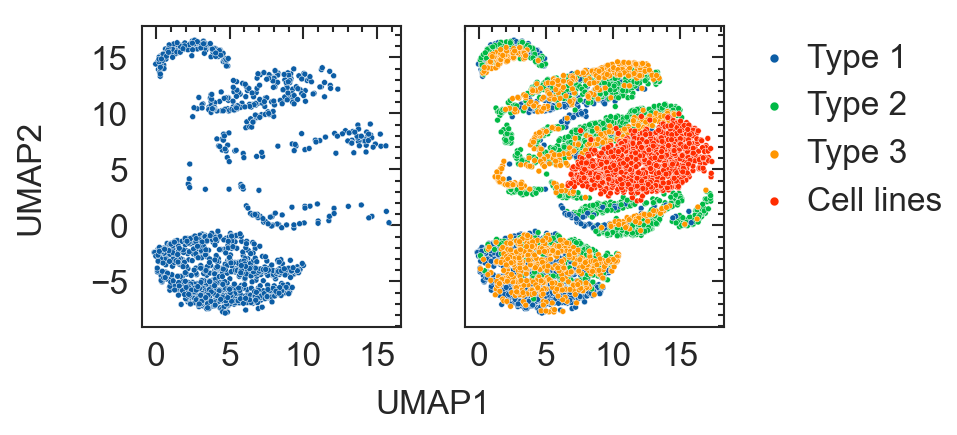

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2.5, 1.3), sharey=True)
plt.subplots_adjust(wspace=0.25, hspace=0.25)

# g1 = sns.scatterplot(x='UMAP1', y='UMAP2', data=sc_umap.loc[sc_umap['tumor_type'] == 'Type 1', :], hue='tumor_type', s=5, ax=ax1, rasterized=True)
g1 = sns.scatterplot(x='UMAP1', y='UMAP2', data=sc_umap.loc[sc_umap['tumor_type'] == 'Type 1', :], 
                     hue='tumor_type', s=2, ax=ax1, rasterized=True)
g1.legend([],[], frameon=False)
# g1legend = g1.legend(fontsize=8, loc='lower right')
# g1legend.legendHandles[0].set_sizes([2])
# sns.move_legend(ax1, "lower left", bbox_to_anchor=(-.05, 1), ncol=2, title=None, frameon=False)
ax1.set_xlabel('')
ax1.set_xticks([0, 5, 10, 15])
ax1.set_ylabel('')
ax1.set_yticks([-5, 0, 5, 10, 15])
# ax1.tick_params(labelsize=12)

g2 = sns.scatterplot(x='UMAP1', y='UMAP2', data=sc_umap, hue='tumor_type', s=2, ax=ax2, rasterized=True)
g2legend = g2.legend()
for _ in g2legend.legendHandles:
    _.set_sizes([1])
sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1), ncol=1, title=None, frameon=False, fontsize=8, borderpad=0, handletextpad=0)
ax2.set_xlabel('')
ax2.set_xticks([0, 5, 10, 15])
ax2.set_ylabel('')
ax2.set_yticks([-5, 0, 5, 10, 15])
# ax2.tick_params(labelsize=12)
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
# plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'merged_sc_dataset_single_tumor_type.svg'), dpi=300)

In [11]:
del sc_dataset

#### Cell proportion

In [12]:
cell_frac = np.array([0.08, 0.02, 0.04, 0.03, 0.09, 0.18, 0.08, 0.02, 0.02, 0.04, 0.4])
cell_frac.sum()

1.0

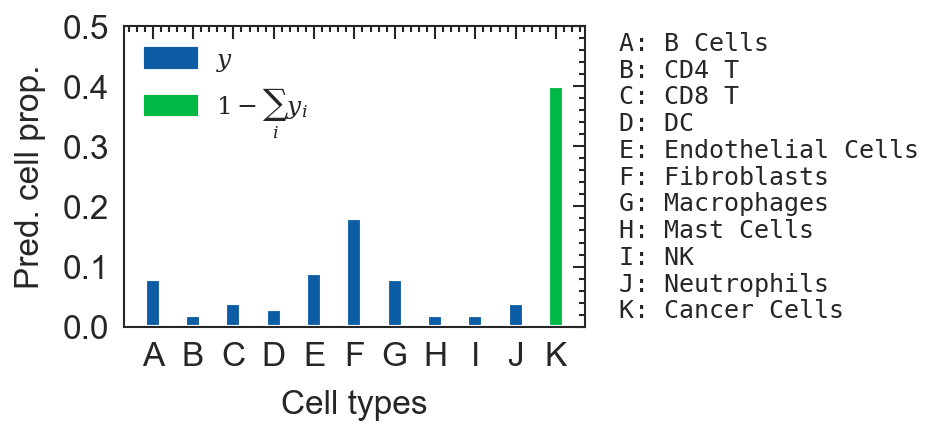

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(3, 1.3), sharey=True)
gs = axs[0].get_gridspec()
# remove the underlying axes
for ax in axs[0:2]:
    ax.remove()
ax1 = fig.add_subplot(gs[0:2])
plt.subplots_adjust(wspace=0.05, hspace=0.05)
colors = ['C0'] * 10 + ['C1']

ax1.bar(range(len(cell_frac)), cell_frac, width=.4, color=colors)
ax1.set_xlabel('Cell types')
ax1.set_xticks(ticks=range(11), labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K'])
ax1.set_yticks([0, 0.10, .20, .30, .40, .5])
ax1.set_ylabel('Pred. cell prop.')

g2c = {'$y$': colors[0], f'$1-\sum_i y_i$': colors[-1]}
handles = [plt.Rectangle((0,0),1,1, color=c) for g, c in g2c.items()]
g2legend = ax1.legend(handles, g2c.keys(), fontsize=6)

axs[2].set_axis_off()
keys = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
cell_types = ['B Cells', 'CD4 T', 'CD8 T', 'DC', 'Endothelial Cells', 'Fibroblasts', 'Macrophages', 'Mast Cells', 'NK', 'Neutrophils', 'Cancer Cells']
y_coor = np.linspace(0.03, 0.92, 11)[::-1]
for inx, k_v in enumerate(list(zip(keys, cell_types))):
    axs[2].text(0.1, y_coor[inx], s=': '.join(k_v), fontsize=6, fontname='monospace')
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     plt.text(
#         rect.get_x() + rect.get_width() / 2, height + 0.002, label, ha="center", va="bottom", fontsize=6
#     )

# plt.tick_params(labelsize=12)
# plt.legend(fontsize=5)
# plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'cell_fraction.svg'), dpi=300)

#### Sampling method comparison
- Generated cell proportion matrix (P) by each method
    - random sampling
    - segment

In [14]:
# tcga_tpm_file_path = '../datasets/TCGA/tpm/merged_tpm.csv'
N100K_random_file_path = '../datasets/simulated_bulk_cell_dataset/random_7ds_n_base100/generated_frac_Mixed_N100K_random.csv'
N100K_segment_without_filtering_file_path = '../datasets/simulated_bulk_cell_dataset/segment_7ds_0.95_n_base100_median_gep/generated_frac_Mixed_N100K_segment_without_filtering.csv'

In [15]:
n100_random_cell_frac = pd.read_csv(N100K_random_file_path, index_col=0)
print(n100_random_cell_frac.shape)
n100_random_cell_frac.head(2)

(100000, 11)


,B Cells,CD4 T,CD8 T,Cancer Cells,DC,Endothelial Cells,Fibroblasts,Macrophages,Mast Cells,NK,Neutrophils
s_random_0_0,0.12,0.04,0.08,0.13,0.13,0.05,0.09,0.13,0.10,0.08,0.06
s_random_0_1,0.08,0.12,0.16,0.11,0.08,0.02,0.14,0.08,0.14,0.05,0.02


In [16]:
# N10_segment_no_filtering_file_path = '../datasets/simulated_bulk_cell_dataset/segment_n_base3_N100_7ds_0.95/simu_bulk_exp_Mixed_N10_without_filtering_log2cpm1p.h5ad'
n100_segment_cell_frac_no_filtering = pd.read_csv(N100K_segment_without_filtering_file_path, index_col=0)
print(n100_segment_cell_frac_no_filtering.shape)
n100_segment_cell_frac_no_filtering.head(2)

(100000, 11)


,B Cells,CD4 T,CD8 T,Cancer Cells,DC,Endothelial Cells,Fibroblasts,Macrophages,Mast Cells,NK,Neutrophils
s_segment_0_1,0.1580,0.0004,0.1861,0.0929,0.0066,0.0943,0.4149,0.0120,0.0177,0.0171,0.0000
s_segment_0_10,0.2923,0.0516,0.0017,0.1109,0.0147,0.0480,0.0076,0.0016,0.4678,0.0037,0.0001


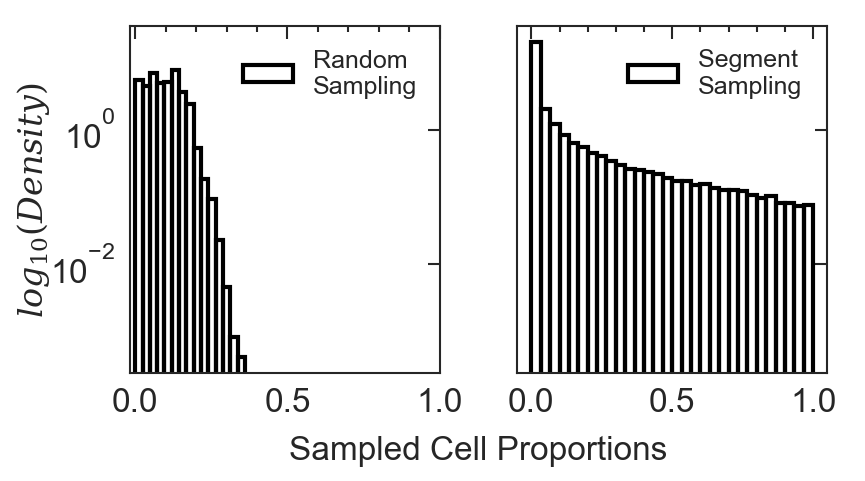

In [17]:
# plt.figure(figsize=(8, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3, 1.5), sharey=True)
plt.subplots_adjust(wspace=0.25, hspace=0.25)

ax1.hist(n100_random_cell_frac['Cancer Cells'], label='Random \nSampling', density=True, histtype='bar', bins=15, fill=False, edgecolor='black')
ax1.set_yscale('log')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.legend(fontsize=6, loc='upper right')
x_min, x_max = ax1.get_xlim()
ax1.set_xticks([0.0, 0.5, 1.0])
# ax1.text(x=0.35, y=0.00035, s='Cell prop.')

ax2.hist(n100_segment_cell_frac_no_filtering['Cancer Cells'], label='Segment \nSampling', density=True, histtype='bar', bins=30, fill=False, edgecolor='black')
ax2.set_yscale('log')
ax2.set_xlabel('')
ax2.legend(fontsize=6, loc='upper right')

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Sampled Cell Proportions")
plt.ylabel("$log_{10}(Density)$")

plt.savefig(os.path.join(fig_dir, 'cell_proportion_comparison.svg'), dpi=300)

#### Mapping the simulated datasets into the PCA space of TCGA

In [18]:
def get_pca_df(file_path, pca_model, dataset_name, gene_list=None):
    exp = ReadH5AD(file_path).get_df()
    if gene_list is not None:
        exp_obj = ExpObj(exp, exp_type='log_space')
        exp_obj.align_with_gene_list(gene_list)
        exp = exp_obj.get_exp()
    print(exp.shape)
    exp_pca = pca_model.transform(exp.values)
    exp_pca_df = pd.DataFrame(data=exp_pca, index=exp.index, columns=['PC1', 'PC2'])
    exp_pca_df['dataset'] = dataset_name
    return exp_pca_df

In [19]:
tcga_tpm = pd.read_csv('../datasets/TCGA/tpm/merged_tpm.csv', index_col=0)
print(tcga_tpm.shape)
tcga_tpm.head(2)

(7699, 19712)


,TRIM71,CCR4,GLB1,TMPPE,CRTAP,SUSD5,FBXL2,UBP1,CLASP2,MATN1,...,GADL1,STT3B,OSBPL10,ZNF860,GPD1L,CMTM8,CMTM7,CMTM6,DYNC1LI1,CNOT10
TCGA-OR-A5LO-01A,0.00,0.017,38.699,0.348,47.470,4.111,6.210,10.764,11.583,0.357,...,0.007,46.981,3.398,0.488,76.426,194.197,17.441,23.289,9.881,10.631
TCGA-P6-A5OG-01A,0.04,0.320,34.088,1.190,113.829,4.699,4.788,28.043,6.925,0.025,...,0.000,97.026,5.841,0.518,11.899,47.232,34.115,60.080,22.208,19.748


##### N_100K_segment (D1)

In [20]:
d1_file_path = '../datasets/simulated_bulk_cell_dataset/segment_7ds_0.95_n_base100_median_gep/simu_bulk_exp_Mixed_N100K_segment_log2cpm1p_filtered_by_high_corr_gene_and_quantile_range_q_5.0_q_95.0.h5ad'
d1 = ReadH5AD(d1_file_path).get_df()
print(d1.shape)
d1.head(2)

(100000, 6168)


,A2M,A4GALT,AAMDC,AASS,AATK,ABAT,ABCA2,ABCA6,ABCA7,ABCB1,...,ZSCAN18,ZSCAN30,ZSCAN9,ZSWIM4,ZSWIM6,ZSWIM8,ZWINT,ZYG11B,ZYX,ZZEF1
s_segment_0_1033,10.331,5.966,7.303,5.004,3.614,4.240,4.475,0.639,5.443,5.662,...,6.446,4.486,4.127,5.560,5.451,5.401,5.447,5.131,7.573,5.320
s_segment_0_104,6.212,4.301,7.276,3.197,3.697,4.443,4.908,1.425,5.549,1.853,...,4.542,2.445,3.366,4.187,5.241,5.989,6.485,4.922,7.531,5.464


In [21]:
tcga_obj = ExpObj(tcga_tpm, exp_type='TPM')
tcga_obj.align_with_gene_list(gene_list=d1.columns.to_list())
tcga_obj.to_log2cpm1p()
tcga_log = tcga_obj.get_exp()
print(tcga_log.shape)
tcga_log.head(2)

6168 common genes will be used, 13544 genes will be removed.
(7699, 6168)


,A2M,A4GALT,AAMDC,AASS,AATK,ABAT,ABCA2,ABCA6,ABCA7,ABCB1,...,ZSCAN18,ZSCAN30,ZSCAN9,ZSWIM4,ZSWIM6,ZSWIM8,ZWINT,ZYG11B,ZYX,ZZEF1
TCGA-OR-A5LO-01A,8.604,5.940,6.876,5.592,2.495,7.583,5.379,0.515,5.288,8.028,...,6.356,4.408,4.341,5.573,4.910,7.145,6.241,5.722,7.087,4.889
TCGA-P6-A5OG-01A,9.937,5.856,6.346,4.953,3.503,1.557,5.824,2.009,4.224,2.229,...,4.977,4.170,4.442,4.650,6.718,5.348,8.018,4.585,9.087,4.474


In [22]:
np.all(d1.columns == tcga_log.columns)

True

##### PCA

In [23]:
pca = PCA(n_components=2)
pca_by_tcga = pca.fit(tcga_log.values)

In [24]:
pca_by_tcga.explained_variance_ratio_

array([0.16715667, 0.09757412])

In [25]:
tcga_cancer_type = pd.read_csv('../datasets/TCGA/tpm/tcga_sample_id2cancer_type.csv', index_col=0)
tcga_cancer_type.head(2)

,cancer_type
TCGA-OR-A5LO-01A,ACC
TCGA-P6-A5OG-01A,ACC


In [26]:
tcga_pca = pca_by_tcga.transform(tcga_log.values)
tcga_pca_df = pd.DataFrame(data=tcga_pca, index=tcga_log.index, columns=['PC1', 'PC2'])
tcga_pca_df['dataset'] = 'TCGA'
tcga_pca_df.head(2)

,PC1,PC2,dataset
TCGA-OR-A5LO-01A,46.333502,40.045285,TCGA
TCGA-P6-A5OG-01A,3.178714,3.283232,TCGA


In [27]:
tcga_pca_df2 = tcga_pca_df.merge(tcga_cancer_type, left_index=True, right_index=True)
print(tcga_pca_df2.shape)
tcga_pca_df2.head(2)

(7699, 4)


,PC1,PC2,dataset,cancer_type
TCGA-OR-A5LO-01A,46.333502,40.045285,TCGA,ACC
TCGA-P6-A5OG-01A,3.178714,3.283232,TCGA,ACC


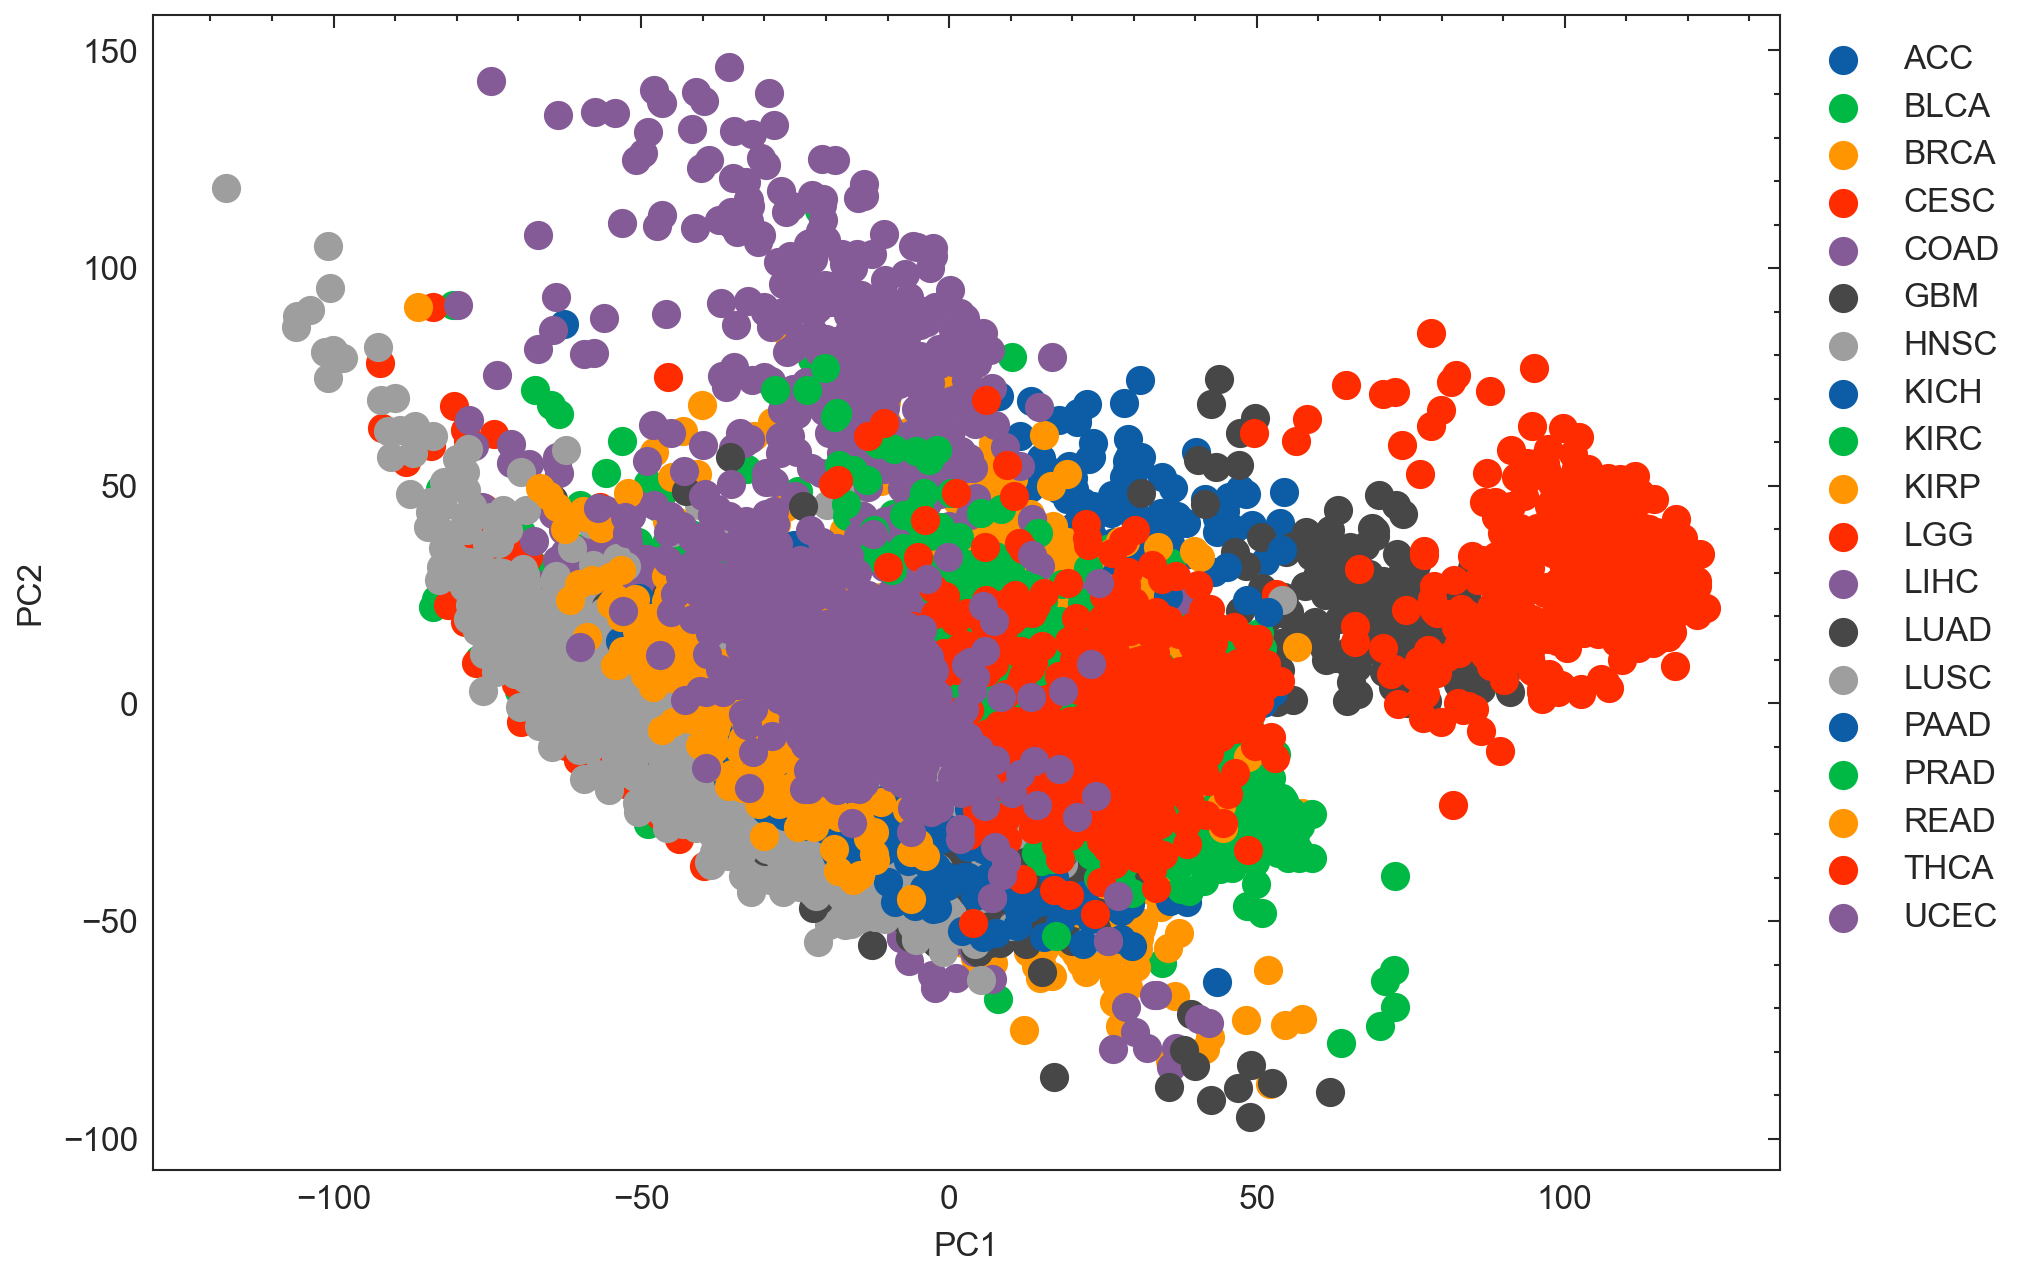

In [28]:
plt.figure(figsize=(7, 5))
for cancer_type, group in tcga_pca_df2.groupby('cancer_type'):
    plt.scatter(group['PC1'], group['PC2'], label=cancer_type)
plt.legend(loc='upper left', bbox_to_anchor=(1., 1), ncol=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig(os.path.join(fig_dir, 'TCGA_PCA.png'), dpi=300)

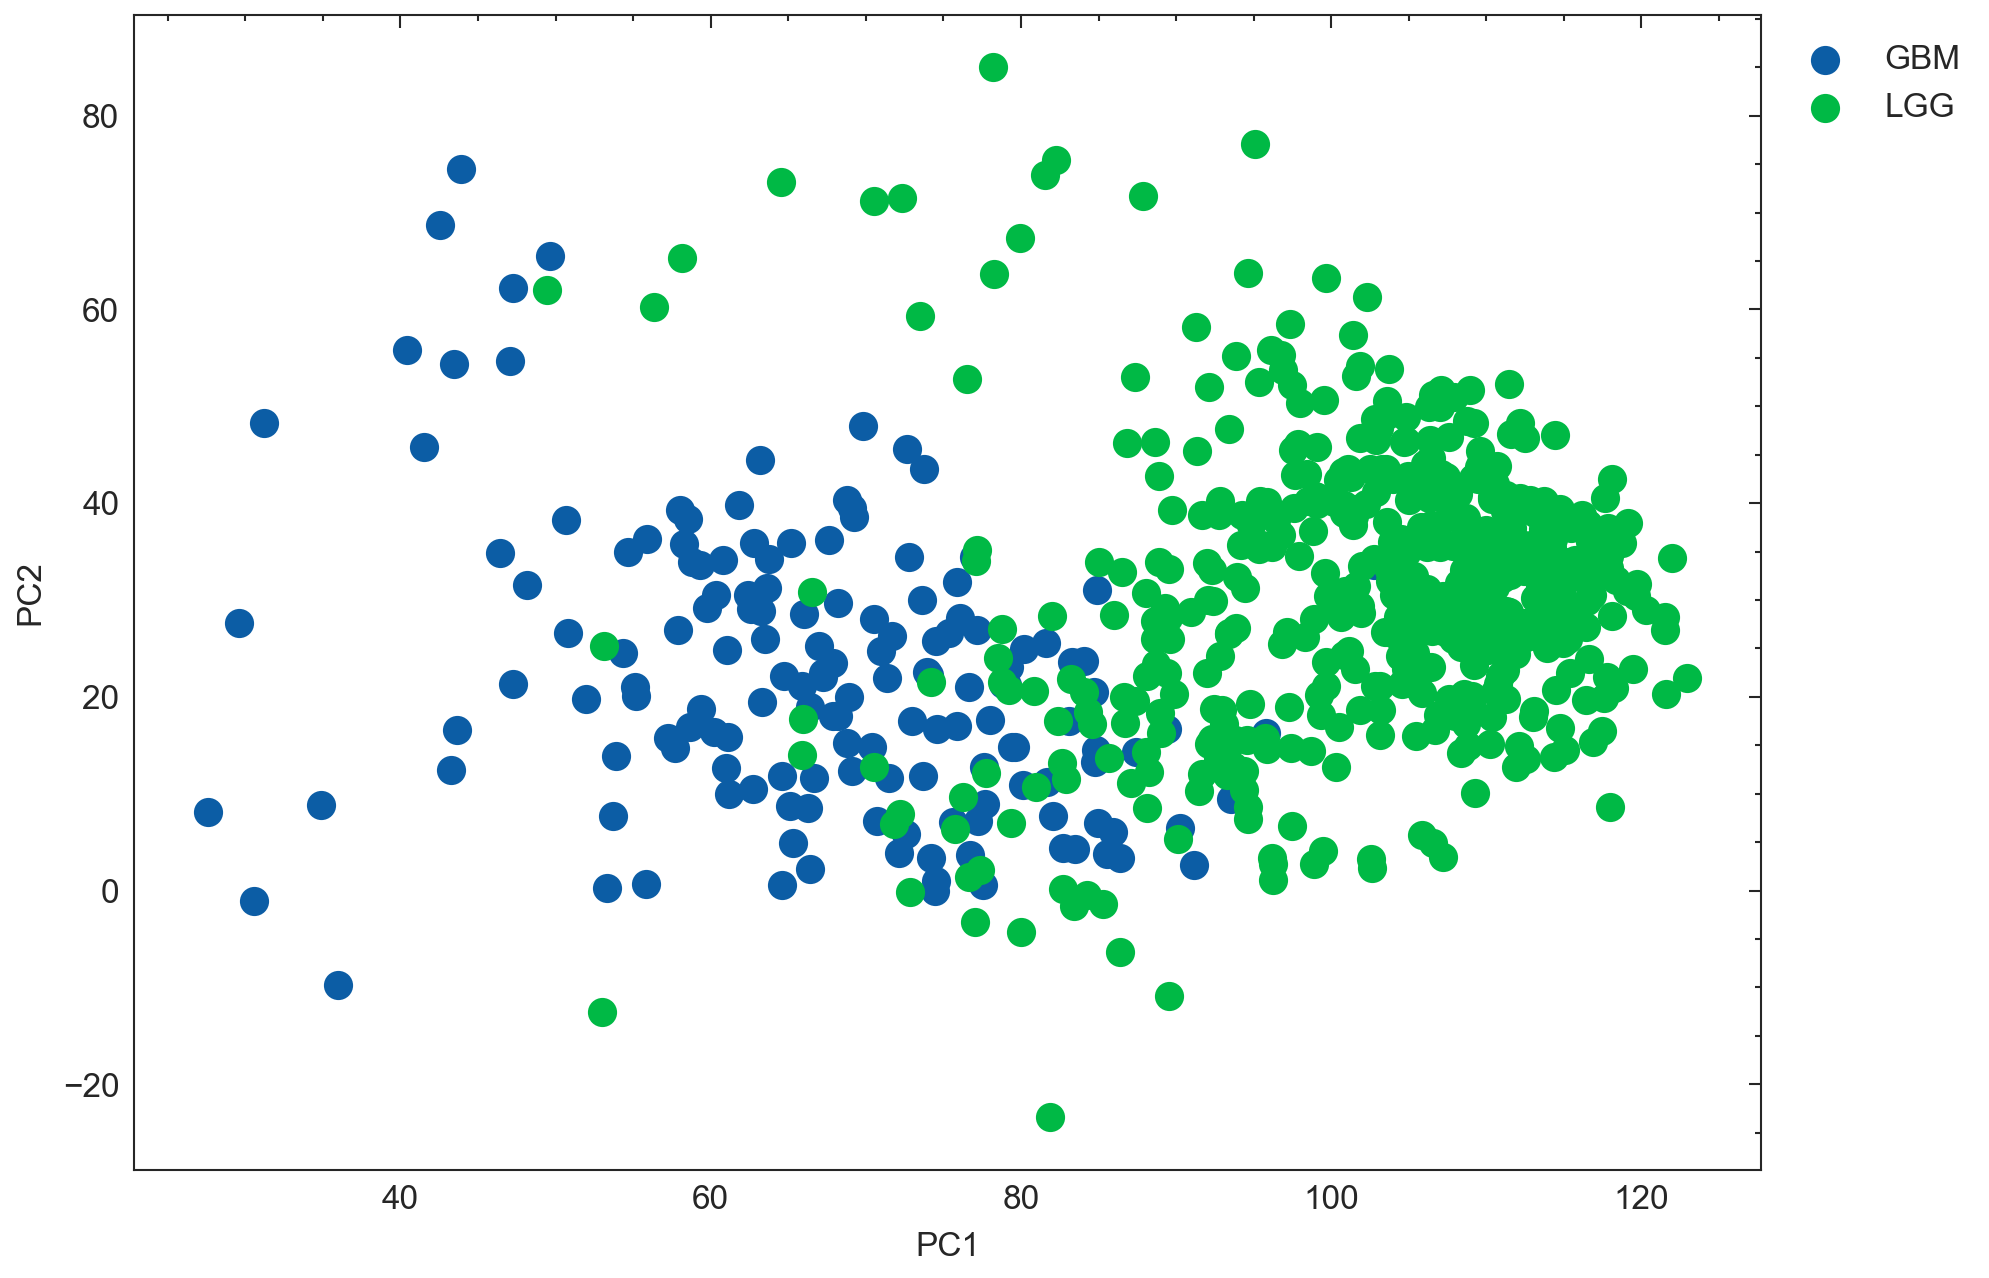

In [29]:
plt.figure(figsize=(7, 5))
for cancer_type, group in tcga_pca_df2.groupby('cancer_type'):
    if cancer_type in ['GBM', 'LGG']:
        plt.scatter(group['PC1'], group['PC2'], label=cancer_type)
plt.legend(loc='upper left', bbox_to_anchor=(1., 1), ncol=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig(os.path.join(fig_dir, 'TCGA_PCA_gbm_lgg.png'), dpi=300)

In [30]:
n_100k_random_file_path = '../datasets/simulated_bulk_cell_dataset/random_7ds_n_base100/simu_bulk_exp_Mixed_N100K_random_log2cpm1p.h5ad'
n_100k_random_pca_df = get_pca_df(n_100k_random_file_path, pca_model=pca_by_tcga, gene_list=d1.columns.to_list(), dataset_name='D0')
n_100k_random_pca_df.head(2)

6168 common genes will be used, 5946 genes will be removed.
(100000, 6168)


,PC1,PC2,dataset
s_random_0_0,19.645046,-38.861283,D0
s_random_0_1,15.445208,-35.354793,D0


In [31]:
d1_pca_df = get_pca_df(d1_file_path, pca_model=pca_by_tcga, dataset_name='D1')
d1_pca_df.head(2)

(100000, 6168)


,PC1,PC2,dataset
s_segment_0_1033,15.420942,-28.465849,D1
s_segment_0_104,-12.603583,-13.673741,D1


In [32]:
d2_file_path = '../datasets/simulated_bulk_cell_dataset/segment_7ds_0.95_n_base100_median_gep/simu_bulk_exp_Mixed_N100K_segment_without_filtering_log2cpm1p.h5ad'
d2_pca_df = get_pca_df(d2_file_path, pca_model=pca_by_tcga, gene_list=d1.columns.to_list(), dataset_name='D2')
d2_pca_df.head(2)

6168 common genes will be used, 5946 genes will be removed.
(100000, 6168)


,PC1,PC2,dataset
s_segment_0_1,22.851363,-31.277852,D2
s_segment_0_10,10.293762,-11.971897,D2


In [33]:
d2_pca_df_down_sampled = d2_pca_df.sample(n=tcga_pca_df.shape[0])
d1_pca_df_down_sampled = d1_pca_df.sample(n=tcga_pca_df.shape[0])
n_100k_random_pca_df_down_sampled = n_100k_random_pca_df.sample(n=tcga_pca_df.shape[0])

In [34]:
pca_by_tcga_d1_gene_list = pd.concat([tcga_pca_df, d2_pca_df_down_sampled, d1_pca_df_down_sampled, n_100k_random_pca_df_down_sampled])
print(pca_by_tcga_d1_gene_list.shape)
pca_by_tcga_d1_gene_list.head(2)

(30796, 3)


,PC1,PC2,dataset
TCGA-OR-A5LO-01A,46.333502,40.045285,TCGA
TCGA-P6-A5OG-01A,3.178714,3.283232,TCGA


In [35]:
dataset2color = {'TCGA': 'C5', 'D0': 'C0', 'D1': 'C1', 'D2': 'C2'}

In [36]:
# pca_by_tcga_d1_gene_list.to_csv('pca_by_tcga_d1_gene_list_4ds.csv', index_label='sample_index')

/home/phyxiongx/.conda/envs/ds/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


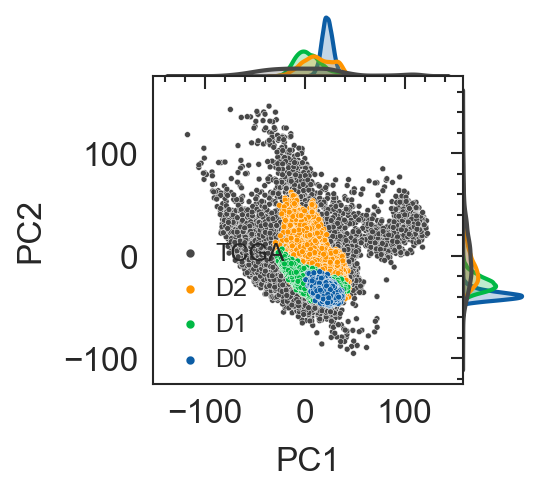

In [37]:
g1 = sns.jointplot(x=f'PC1', y=f'PC2', data=pca_by_tcga_d1_gene_list, kind='scatter', 
                   hue='dataset', s=2, height=1.6, space=0, rasterized=True, palette=dataset2color)
g1_ax = g1.ax_joint
# g1_ax.set_xticks([-5, 0.0, 5.0])
g1legend = g1_ax.legend(loc='lower left', fontsize=6, borderpad=0, handletextpad=0)
for _ in g1legend.legendHandles:
    _.set_sizes([1])
# sns.despine(g1_ax)
g1.ax_marg_x.tick_params(axis='x', which='both', top=False)
g1.ax_marg_x.grid(False)
g1.ax_marg_y.tick_params(axis='y', which='both', right=False)
g1.ax_marg_y.grid(False)

plt.savefig(os.path.join(fig_dir, 'pca_by_tcga_d1_gene_list_4ds_comparison.svg'), dpi=300)

#### Comparing simulated dataset and TCGA in latent space

##### Mixed_N100_segment_filtered

In [38]:
l_first_pca_lower_dim_sf = pd.read_csv(os.path.join(result_dir, 'Mixed_N100K_segment_filtered/l_first_pca_lower_dim.csv'), index_col=0)
selected_part1 = l_first_pca_lower_dim_sf.loc[l_first_pca_lower_dim_sf['class'] == 'TCGA', :]
selected_part2 = l_first_pca_lower_dim_sf.loc[l_first_pca_lower_dim_sf['class'] == 'D1', :]
l_first_pca_lower_dim_sf = l_first_pca_lower_dim_sf.loc[l_first_pca_lower_dim_sf.index.isin(selected_part1.index.to_list() + selected_part2.index.to_list()), :].copy()
print(l_first_pca_lower_dim_sf.shape)
# l_first_pca_lower_dim_sf['class'] = l_first_pca_lower_dim_sf['class'].map({'TCGA': 'TCGA', 'Mix_N100K_SF': 'D1'})
l_first_pca_lower_dim_sf.head(2)

(107699, 5)


,dataset_name,PC1,PC2,PC3,class
index,,,,,
s_segment_0_1033,Mixed_N100K_segment_filtered,-0.080805,1.395423,2.139186,D1
s_segment_0_104,Mixed_N100K_segment_filtered,-1.254546,-1.884122,0.022636,D1


/home/phyxiongx/.conda/envs/ds/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


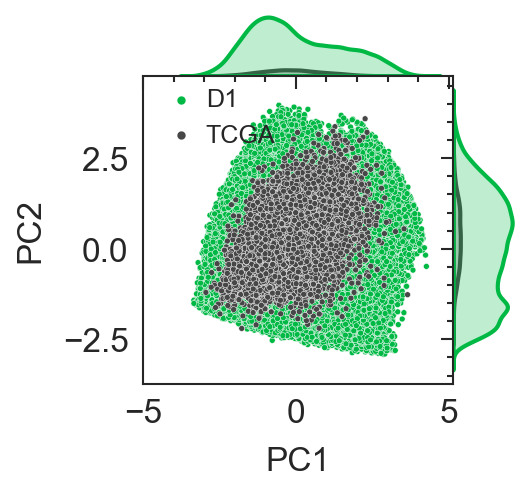

In [39]:
# plt.figure(figsize=(3, 2.5))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5), sharey=True)
# plt.subplots_adjust(wspace=0.4, hspace=0.25)
g1 = sns.jointplot(x=f'PC1', y=f'PC2', data=l_first_pca_lower_dim_sf, kind='scatter', 
                   hue='class', s=2, height=1.6, space=0, rasterized=True, palette=dataset2color)
g1_ax = g1.ax_joint
g1_ax.set_xticks([-5, 0.0, 5.0])
g1legend = g1_ax.legend(loc='upper left', fontsize=6, borderpad=0, handletextpad=0)
for _ in g1legend.legendHandles:
    _.set_sizes([1])
# sns.despine(g1_ax)
g1.ax_marg_x.tick_params(axis='x', which='both', top=False)
g1.ax_marg_x.grid(False)
g1.ax_marg_y.tick_params(axis='y', which='both', right=False)
g1.ax_marg_y.grid(False)

plt.savefig(os.path.join(fig_dir, 'l1_pca_mixed_n100_segment_filtered.svg'), dpi=300)